# genetic algorithm 遗传算法

### 1.Application

1. 寻找函数全局的最优解（最大值或者最小值）
2. 机器学习中优化模型的超参数
3. 旅行商问题：寻找最短路径
4. 背包问题： 在限制下使得总价值（目标函数）最大化
5. 任务分配问题

### 2. Algorithm

1. 核心思想 ： 模拟种群进化，其本质是通过**选择、交叉、变异**操作，像最优解进化
2. 基本概念 ： 
  * Individual 个体 ： 一个候选解
  * population 种群 ： 一组个体，代表当前搜索的解空间
  * Fitness Function 适应度函数 : 衡量个体优劣的标准
3. 工作流程 ： 
  * 对问题编码 ： 1.二进制编码,适用于离散问题 2.实数编码，适用于连续问题 3. 排列编码 ：适用于组合优化问题
  * 初始化种群 ： 1.随机初始化，随机生成满足变量范围的解 2.启发式初始化 ；利用先验知识生成初始解
  ```
     def initialize_population(pop_size,bounds)
      # 随机生成满足变量范围内的解
        return np.random.uniform(bounds[0],bounds[1],pop_size)
  ```
  * 计算适应度函数 ： 
  ```    
    def fitness_function(x):
       # 例如：求函数 f(x) = x * sin(10π * x) + 2.0 的最大值
            return x * np.sin(10 * np.pi * x) + 2.0
  ```
  * 适应度处理： 如果我们在后续的选择过程中选择轮盘赌选择法，我们将要对这些数据进行处理
  ```
  def scale_fitness(fitness):
    fitness_min = np.min(fitness)
    if fitness_min < 0:
        fitness = fitness - fitness_min + 1e-10  # 确保所有适应度为正
    
    # 防止全零情况
    if np.sum(fitness) == 0:
        return np.ones_like(fitness) / len(fitness)
    
    # 幂次缩放，提高选择压力
    scaled_fitness = fitness ** 1.5
    
    return scaled_fitness
  ```
  * 选择操作 ： 根据适应度选择优秀个体
  ```    
    def select_parents(population, fitness):
       # 轮盘赌选择法
            probs  = fitness / fitness.sum()
            selected_indices  =  np.random.choice(len(population),size=len(population),p=probs)
            return population[selected_indices]
  ```
    假如适应度函数为负数，那么可以使用适应度函数平移的方法
  ``` 
      shifted_fitness = fitness - np.min(fitness)
  ```
  * 交叉操作 ： 产生新一代个体
  ```   
def crossover(parents, crossover_rate):
    offspring = parents.copy()
    for i in range(0, len(parents), 2):
        if i+1 < len(parents) and np.random.random() < crossover_rate:
            beta = np.random.random()
            offspring[i] = parents[i] * beta + parents[i+1]*(1-beta)
            offspring[i+1] = parents[i+1] * beta + parents[i]*(1-beta)
    return offspring
  ```
  自适应变异率
```
  def adaptive_mutation_rate(initial_rate, current_gen, max_gen, min_rate=0.01):
    """
    根据进化代数动态调整变异率
    
    参数:
        initial_rate (float): 初始变异率
        current_gen (int): 当前代数
        max_gen (int): 最大代数
        min_rate (float): 最小变异率
        
    返回:
        float: 调整后的变异率
    """
    decay = (initial_rate - min_rate) * (current_gen / max_gen)
    return max(initial_rate - decay, min_rate)
```
  * 变异操作 ： 维持种群多样性
  ```    
  def mutate(offspring,mutate_rate,bounds):
          # mask 是用于记录每一个个体是否将发生变异数组
          mask = np.random.random(len(offspring)) < mutate_rate
          #生成变异值，变异值满足正态分布
          mutation = np.random.normal(0,0.1,len(offspring))
          offspring[mask] += mutation[mask]
          offspring = np.clip(offspring, bounds[0], bounds[1])
          return offspring
  ```

   精英保留策略
def elitism(population, fitness, offspring, elite_count=1):
    """
    保留当前种群中最优的个体到下一代
    
    参数:
        population (numpy.ndarray): 当前种群
        fitness (numpy.ndarray): 当前种群的适应度
        offspring (numpy.ndarray): 子代种群
        elite_count (int): 要保留的精英数量
        
    返回:
        numpy.ndarray: 应用精英策略后的子代
    """
    # 找出当前种群中最优的elite_count个个体
    elite_indices = np.argsort(fitness)[-elite_count:]
    elites = population[elite_indices]
    
    # 随机替换子代中的个体
    for i in range(elite_count):
        replace_idx = np.random.randint(0, len(offspring))
        offspring[replace_idx] = elites[i]
    
    return offspring

 收敛检测
def check_convergence(fitness_history, window=20, threshold=1e-6):
    """
    检查算法是否已收敛
    
    参数:
        fitness_history (list): 适应度历史记录
        window (int): 检查的窗口大小
        threshold (float): 收敛阈值
        
    返回:
        bool: 是否已收敛
    """
    if len(fitness_history) < window:
        return False
    
    recent_fitness = fitness_history[-window:]
    improvement = np.max(recent_fitness) - np.min(recent_fitness)
    
    return improvement < threshold

  * 迭代操作 ：将上述过程持续进行直到达到最大迭代次数或者满足停止条件
  ``` 
  def genetic_algorithm (bounds,pop_size,mutate_rate,max_iter,crossover_rate,mutation_rate):
          #初始化种群
          population = initialize_population(pop_size,bounds)
          best_fitness_history = []
          avg_fitness_history = []
          best_individual = None 
          best_fitness = float('-inf')

          for i in range(max_iter):
            #计算适应度
            fitness = np.array(fitness_function(ind) for ind in population)

            #记录最优个体
            current_best_index = np.argmax(fitness)
            if fitness[current_best_index] > best_fitness:
              best_fitness = fitness[current_best_index]
              best_individual = population[current_best_idx]

            # 记录历史数据
            best_fitness_history.append(current_best_fitness)
            avg_fitness_history.append(np.mean(fitness))

            # 选择操作
            parents = select_parents(population,fitness)

            #交叉操作
            offspring = crossover(parents)

            
            #变异操作
            offspring = mutate(offspring,mutate_rate,bounds)

            # 精英保留策略
            elite_idx = np.argmax(fitness)
            elite_individual = population[elite_idx]
            worst_idx = np.argmin([fitness_function(ind) for ind in offspring])
            offspring[worst_idx] = elite_individual

            # 更新种群

            population = offspring

            # 输出当代最优解

            print(f"Generation {i+1}: Best Fitness = {best_fitness}")
          return best_individual, best_fitness, best_fitness_history, avg_fitness_history


            
            



          

             


### 对于适应度函数为负数的情况处理

1. 适应度平移
```
   def handle_negative_fitness(fitness):
    # 找出最小适应度值
    min_fitness = np.min(fitness)
    
    # 如果存在负值，进行平移
    if min_fitness < 0:
        # 平移量稍大于最小值的绝对值，确保所有值为正
        shift_value = abs(min_fitness) + 1e-10
        shifted_fitness = fitness + shift_value
        return shifted_fitness
    
    return fitness
```

2. 锦标赛选择法
```
def tournament_selection(population, fitness, tournament_size=3):
    selected = np.zeros_like(population)
    
    for i in range(len(population)):
        # 随机选择tournament_size个个体
        competitors = np.random.choice(len(population), tournament_size, replace=False)
        
        # 选择适应度最高的个体
        winner = competitors[np.argmax(fitness[competitors])]
        selected[i] = population[winner]
    
    return selected
```


## 例题一：寻找 f(x) = x^2 - 4x + 4 在 [-10,10]上面的最小值


In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# 设置全局字体为支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题


In [16]:
import numpy as np

# 首先定义目标函数 ： 
def objective_function(x):
    return x**2 - 4*x + 4

# 定义适应度函数 ,求最小值适应度函数是目标函数的负数: 
def fitness_function(x):
    return -objective_function(x)

#初始化种群
def initialize_population(pop_size,bounds):
    # 随机生成满足变量范围内的解
    return np.random.uniform(bounds[0],bounds[1],pop_size)

#选择 ： 对于适应度函数可能为负数的我们使用锦标赛进行选择
def tournament_selection(population, fitness, tournament_size=3):
    selected = np.zeros_like(population)
    
    for i in range(len(population)):
        # 随机选择tournament_size个个体
        competitors = np.random.choice(len(population), tournament_size, replace=False)
        
        # 选择适应度最高的个体
        winner = competitors[np.argmax(fitness[competitors])]
        selected[i] = population[winner]
    
    return selected

#交叉操作：
def crossover(parents, crossover_rate):
    offspring = parents.copy()
    for i in range(0, len(parents), 2):
        if i+1 < len(parents) and np.random.random() < crossover_rate:
            beta = np.random.random()
            offspring[i] = parents[i] * beta + parents[i+1]*(1-beta)
            offspring[i+1] = parents[i+1] * beta + parents[i]*(1-beta)
    return offspring

#变异操作
def mutate(offspring,mutate_rate,bounds):
        # mask 是用于记录每一个个体是否将发生变异数组
        mask = np.random.random(len(offspring)) < mutate_rate
        #生成变异值，变异值满足正态分布
        mutation = np.random.normal(0,0.1,len(offspring))
        offspring[mask] += mutation[mask]
        offspring = np.clip(offspring, bounds[0], bounds[1])
        return offspring

# 迭代操作
def genetic_algorithm (bounds,pop_size,mutate_rate,max_iter,crossover_rate):
        #初始化种群
        population = initialize_population(pop_size,bounds)
        best_fitness_history = []
        avg_fitness_history = []
        best_individual = None 
        best_fitness = float('-inf')

        for i in range(max_iter):
            #计算适应度
            fitness = np.array([fitness_function(ind) for ind in population])

            #记录最优个体
            current_best_index = np.argmax(fitness)
            if fitness[current_best_index] > best_fitness:
                best_fitness = fitness[current_best_index]
                best_individual = population[current_best_index]

            # 记录历史数据
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(np.mean(fitness))

            # 选择操作
            parents = tournament_selection(population,fitness)

            #交叉操作

            offspring = crossover(parents,crossover_rate)

            
            #变异操作
            offspring = mutate(offspring,mutate_rate,bounds)

            # 精英保留策略
            elite_idx = np.argmax(fitness)
            offspring[0] = population[elite_idx]

            # 更新种群

            population = offspring

            # 输出当代最优解

            print(f"Generation {i+1}: Best_x = {best_individual}, Best Fitness = {best_fitness}")
        return best_individual, best_fitness, best_fitness_history, avg_fitness_history

#调用遗传函数求解方程
# 设置随机种子
np.random.seed(42)
bounds = [-10,10]
pop_size = 500
mutate_rate =0.1
max_iter =200
crossover_rate =0.8

best_x,best_fitness,best_fitness_history,avg_fitness_history = genetic_algorithm(bounds,pop_size,mutate_rate,max_iter,crossover_rate)


Generation 1: Best_x = 2.0223002348641756, Best Fitness = -0.0004973004749970755
Generation 2: Best_x = 2.017605667177369, Best Fitness = -0.00030995951675993894
Generation 3: Best_x = 1.9922890673527556, Best Fitness = -5.945848229016448e-05
Generation 4: Best_x = 2.001261183609872, Best Fitness = -1.5905840982100017e-06
Generation 5: Best_x = 2.001261183609872, Best Fitness = -1.5905840982100017e-06
Generation 6: Best_x = 2.0001894189315093, Best Fitness = -3.587953134598365e-08
Generation 7: Best_x = 2.0000899536429118, Best Fitness = -8.091658010300762e-09
Generation 8: Best_x = 1.9999663291756113, Best Fitness = -1.1337242256104219e-09
Generation 9: Best_x = 2.000000271090852, Best Fitness = -7.37188088351104e-14
Generation 10: Best_x = 2.000000271090852, Best Fitness = -7.37188088351104e-14
Generation 11: Best_x = 2.000000271090852, Best Fitness = -7.37188088351104e-14
Generation 12: Best_x = 1.9999997391398963, Best Fitness = -6.794564910705958e-14
Generation 13: Best_x = 2.0000

## 例题一答案：

开始运行遗传算法...

Generation 1/100: Best_x = 2.022300, f(x) = 0.000497
Generation 10/100: Best_x = 2.000001, f(x) = 0.000000
Generation 20/100: Best_x = 2.000000, f(x) = 0.000000
已收敛，提前终止于第 24 代

优化完成!
找到的最优解: x = 2.000000
对应函数值: f(x) = 0.000000
与理论最优解 (x=2) 的距离: 0.000000


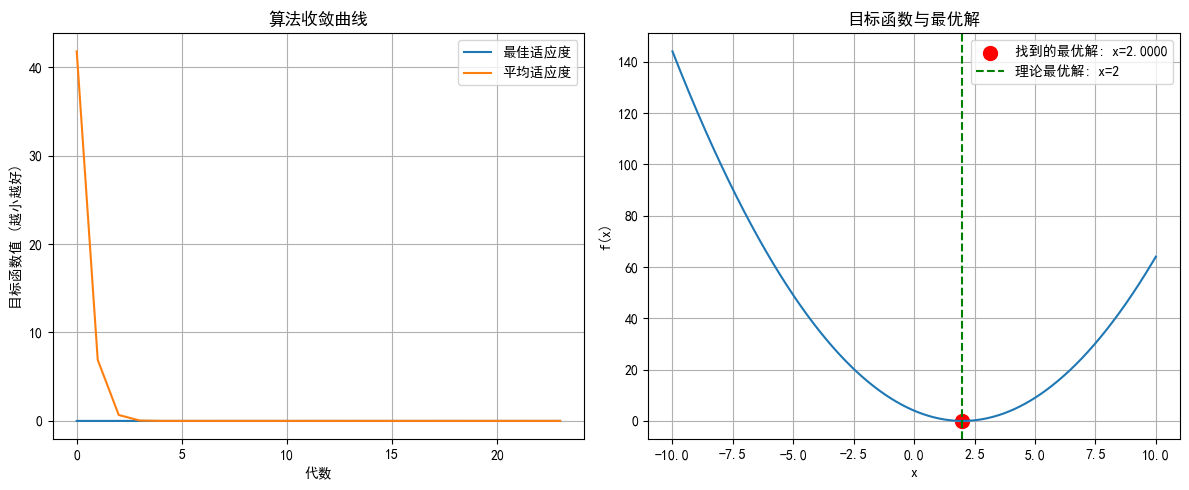

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 目标函数
def objective_function(x):
    return x**2 - 4*x + 4

# 适应度函数（最小化问题，负值表示）
def fitness_function(x):
    return -objective_function(x)

# 适应度缩放
def scale_fitness(fitness):
    """缩放适应度以处理负值和提高选择压力"""
    fitness_min = np.min(fitness)
    if fitness_min < 0:
        fitness = fitness - fitness_min + 1e-10  # 确保所有适应度为正
    
    # 幂次缩放，提高选择压力
    scaled_fitness = fitness ** 1.5
    
    return scaled_fitness

# 初始化种群
def initialize_population(pop_size, bounds):
    """
    随机初始化种群
    
    参数:
        pop_size (int): 种群大小
        bounds (list): 变量边界 [下界, 上界]
        
    返回:
        numpy.ndarray: 初始化的种群
    """
    return np.random.uniform(bounds[0], bounds[1], pop_size)

# 锦标赛选择
def tournament_selection(population, fitness, tournament_size=3):
    """
    使用锦标赛选择机制选择父代
    
    参数:
        population (numpy.ndarray): 当前种群
        fitness (numpy.ndarray): 对应的适应度值
        tournament_size (int): 每次锦标赛选择的竞争者数量
        
    返回:
        numpy.ndarray: 选择后的种群
    """
    selected = np.zeros_like(population)
    
    for i in range(len(population)):
        # 随机选择tournament_size个个体
        competitors = np.random.choice(len(population), tournament_size, replace=False)
        
        # 选择适应度最高的个体
        winner = competitors[np.argmax(fitness[competitors])]
        selected[i] = population[winner]
    
    return selected

# 交叉操作
def crossover(parents, crossover_rate):
    """
    对父代进行算术交叉生成子代
    
    参数:
        parents (numpy.ndarray): 父代种群
        crossover_rate (float): 交叉概率
        
    返回:
        numpy.ndarray: 交叉后的子代
    """
    offspring = parents.copy()
    for i in range(0, len(parents), 2):
        if i+1 < len(parents) and np.random.random() < crossover_rate:
            beta = np.random.random()
            offspring[i] = parents[i] * beta + parents[i+1] * (1-beta)
            offspring[i+1] = parents[i+1] * beta + parents[i] * (1-beta)
    return offspring

# 自适应变异率
def adaptive_mutation_rate(initial_rate, current_gen, max_gen, min_rate=0.01):
    """
    根据进化代数动态调整变异率
    
    参数:
        initial_rate (float): 初始变异率
        current_gen (int): 当前代数
        max_gen (int): 最大代数
        min_rate (float): 最小变异率
        
    返回:
        float: 调整后的变异率
    """
    decay = (initial_rate - min_rate) * (current_gen / max_gen)
    return max(initial_rate - decay, min_rate)

# 变异操作
def mutate(offspring, mutate_rate, bounds):
    """
    对子代进行高斯变异
    
    参数:
        offspring (numpy.ndarray): 子代种群
        mutate_rate (float): 变异概率
        bounds (list): 变量边界 [下界, 上界]
        
    返回:
        numpy.ndarray: 变异后的子代
    """
    # mask 是用于记录每一个个体是否将发生变异数组
    mask = np.random.random(len(offspring)) < mutate_rate
    # 生成变异值，变异值满足正态分布
    mutation = np.random.normal(0, 0.1, len(offspring))
    offspring[mask] += mutation[mask]
    offspring = np.clip(offspring, bounds[0], bounds[1])
    return offspring

# 精英保留策略
def elitism(population, fitness, offspring, elite_count=1):
    """
    保留当前种群中最优的个体到下一代
    
    参数:
        population (numpy.ndarray): 当前种群
        fitness (numpy.ndarray): 当前种群的适应度
        offspring (numpy.ndarray): 子代种群
        elite_count (int): 要保留的精英数量
        
    返回:
        numpy.ndarray: 应用精英策略后的子代
    """
    # 找出当前种群中最优的elite_count个个体
    elite_indices = np.argsort(fitness)[-elite_count:]
    elites = population[elite_indices]
    
    # 随机替换子代中的个体
    for i in range(elite_count):
        replace_idx = np.random.randint(0, len(offspring))
        offspring[replace_idx] = elites[i]
    
    return offspring

# 收敛检测
def check_convergence(fitness_history, window=20, threshold=1e-6):
    """
    检查算法是否已收敛
    
    参数:
        fitness_history (list): 适应度历史记录
        window (int): 检查的窗口大小
        threshold (float): 收敛阈值
        
    返回:
        bool: 是否已收敛
    """
    if len(fitness_history) < window:
        return False
    
    recent_fitness = fitness_history[-window:]
    improvement = np.max(recent_fitness) - np.min(recent_fitness)
    
    return improvement < threshold

# 结果可视化
def plot_results(best_fitness_history, avg_fitness_history, best_x, bounds):
    """
    可视化算法结果
    
    参数:
        best_fitness_history (list): 最佳适应度历史
        avg_fitness_history (list): 平均适应度历史
        best_x (float): 找到的最优解
        bounds (list): 变量边界
    """
    # 绘制收敛曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot([-f for f in best_fitness_history], label='最佳适应度')
    plt.plot([-f for f in avg_fitness_history], label='平均适应度')
    plt.xlabel('代数')
    plt.ylabel('目标函数值 (越小越好)')
    plt.legend()
    plt.title('算法收敛曲线')
    plt.grid(True)
    
    # 绘制目标函数和最优解
    plt.subplot(1, 2, 2)
    x = np.linspace(bounds[0], bounds[1], 1000)
    y = [objective_function(xi) for xi in x]
    plt.plot(x, y)
    plt.scatter(best_x, objective_function(best_x), color='red', s=100, label=f'找到的最优解: x={best_x:.4f}')
    plt.axvline(x=2, color='green', linestyle='--', label='理论最优解: x=2')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('目标函数与最优解')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 遗传算法主函数
def genetic_algorithm(bounds, pop_size=50, mutate_rate=0.1, max_iter=100, crossover_rate=0.8,
                     tournament_size=3, elite_count=1):
    """
    遗传算法主函数
    
    参数:
        bounds (list): 变量边界 [下界, 上界]
        pop_size (int): 种群大小
        mutate_rate (float): 变异概率
        max_iter (int): 最大迭代次数
        crossover_rate (float): 交叉概率
        tournament_size (int): 锦标赛选择大小
        elite_count (int): 精英数量
        
    返回:
        tuple: (最优解, 最优适应度, 最优适应度历史, 平均适应度历史)
    """
    # 参数验证
    if not isinstance(bounds, (list, tuple)) or len(bounds) != 2:
        raise ValueError("边界应为包含两个元素的列表或元组: [lower, upper]")
    if pop_size < 10:
        print("警告: 种群规模太小可能导致性能不佳")
    
    # 初始化种群
    population = initialize_population(pop_size, bounds)
    best_fitness_history = []
    avg_fitness_history = []
    best_individual = None 
    best_fitness = float('-inf')

    # 迭代进化
    for i in range(max_iter):
        # 计算适应度
        fitness = np.array([fitness_function(ind) for ind in population])
        
        # 记录最优个体
        current_best_index = np.argmax(fitness)
        current_best_individual = population[current_best_index]
        current_best_fitness = fitness[current_best_index]
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual

        # 记录历史数据
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(np.mean(fitness))
        
        # 检查是否收敛
        if check_convergence(best_fitness_history):
            print(f"已收敛，提前终止于第 {i+1} 代")
            break

        # 输出进度
        if (i + 1) % 10 == 0 or i == 0 or i == max_iter - 1:
            print(f"Generation {i+1}/{max_iter}: Best_x = {best_individual:.6f}, f(x) = {-best_fitness:.6f}")

        # 适应度缩放
        scaled_fitness = scale_fitness(fitness)
        
        # 选择操作
        parents = tournament_selection(population, scaled_fitness, tournament_size)

        # 交叉操作
        offspring = crossover(parents, crossover_rate)
        
        # 自适应变异率
        current_mutation_rate = adaptive_mutation_rate(mutate_rate, i, max_iter)
        
        # 变异操作
        offspring = mutate(offspring, current_mutation_rate, bounds)

        # 精英保留策略
        offspring = elitism(population, fitness, offspring, elite_count)

        # 更新种群
        population = offspring

    print(f"\n优化完成!")
    print(f"找到的最优解: x = {best_individual:.6f}")
    print(f"对应函数值: f(x) = {objective_function(best_individual):.6f}")
    print(f"与理论最优解 (x=2) 的距离: {abs(best_individual - 2):.6f}")
    
    return best_individual, best_fitness, best_fitness_history, avg_fitness_history

# 主程序
if __name__ == "__main__":
    # 设置随机种子
    np.random.seed(42)  # 设置随机种子以便结果可复现
    
    # 算法参数
    bounds = [-10, 10]
    pop_size = 100  # 将种群大小减小以提高效率
    mutate_rate = 0.1
    max_iter = 100  # 减少迭代次数因为问题较简单
    crossover_rate = 0.8
    tournament_size = 3
    elite_count = 2
    
    print("开始运行遗传算法...\n")
    
    # 运行算法
    best_x, best_fitness, best_fitness_history, avg_fitness_history = genetic_algorithm(
        bounds, pop_size, mutate_rate, max_iter, crossover_rate, tournament_size, elite_count
    )
    
    # 可视化结果
    plot_results(best_fitness_history, avg_fitness_history, best_x, bounds)

## 问题二 ：设计一个矩形，使其周长固定为 100 单位，求矩形面积的最大值。

带约束的优化问题

Generation 1/500: Best_x = 25.075815, f(x) = -624.994252
Generation 10/500: Best_x = 25.001433, f(x) = -624.999998
Generation 20/500: Best_x = 25.000222, f(x) = -625.000000
已收敛，提前终止于第 30 代

优化完成!
找到的最优解: x = 25.000222
对应函数值: f(x) = 625.000000


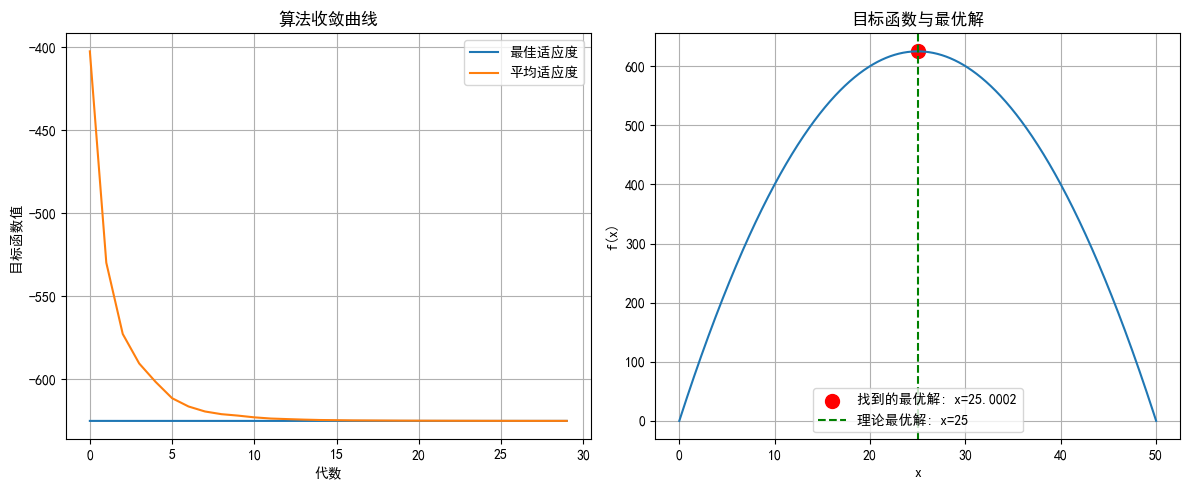

In [49]:
#首先是定义适应度函数：
def objective_function(x):
    if (x<=0):
        return 0
    return x * (50 - x)

def initialize_population(pop_size,bounds):
# 随机生成满足变量范围内的解
    return np.random.uniform(bounds[0],bounds[1],pop_size)

def fitness_function(x):
    return objective_function(x)

def scale_fitness(fitness):
    fitness_min = np.min(fitness)
    if fitness_min < 0:
        fitness = fitness - fitness_min + 1e-10  # 确保所有适应度为正

    # 防止全零情况
    if np.sum(fitness) == 0:
        return np.ones_like(fitness) / len(fitness)

    # 幂次缩放，提高选择压力
    scaled_fitness = fitness ** 1.5

    return scaled_fitness

def select_parents(population, fitness):
    # 轮盘赌选择法
    probs  = fitness / fitness.sum()
    selected_indices  =  np.random.choice(len(population),size=len(population),p=probs)
    return population[selected_indices]

def crossover(parents, crossover_rate):
    offspring = parents.copy()
    for i in range(0, len(parents), 2):
        if i+1 < len(parents) and np.random.random() < crossover_rate:
            beta = np.random.random()
            offspring[i] = parents[i] * beta + parents[i+1]*(1-beta)
            offspring[i+1] = parents[i+1] * beta + parents[i]*(1-beta)
    return offspring

def adaptive_mutation_rate(initial_rate, current_gen, max_gen, min_rate=0.01):
    decay = (initial_rate - min_rate) * (current_gen / max_gen)
    return max(initial_rate - decay, min_rate)

def mutate(offspring,mutate_rate,bounds):
    # mask 是用于记录每一个个体是否将发生变异数组
    mask = np.random.random(len(offspring)) < mutate_rate
    #生成变异值，变异值满足正态分布
    mutation = np.random.normal(0,0.1,len(offspring))
    offspring[mask] += mutation[mask]
    offspring = np.clip(offspring, bounds[0], bounds[1])
    return offspring

def elitism(population, fitness, offspring, elite_count=1):

    # 找出当前种群中最优的elite_count个个体
    elite_indices = np.argsort(fitness)[-elite_count:]
    elites = population[elite_indices]
    
    # 随机替换子代中的个体
    for i in range(elite_count):
        replace_idx = np.random.randint(0, len(offspring))
        offspring[replace_idx] = elites[i]
    
    return offspring

# 收敛检测
def check_convergence(fitness_history, window=20, threshold=1e-6):
    """
    检查算法是否已收敛
    
    参数:
        fitness_history (list): 适应度历史记录
        window (int): 检查的窗口大小
        threshold (float): 收敛阈值
        
    返回:
        bool: 是否已收敛
    """
    if len(fitness_history) < window:
        return False
    
    recent_fitness = fitness_history[-window:]
    improvement = np.max(recent_fitness) - np.min(recent_fitness)
    
    return improvement < threshold


# 结果可视化
def plot_results(best_fitness_history, avg_fitness_history, best_x, bounds):

    # 绘制收敛曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot([-f for f in best_fitness_history], label='最佳适应度')
    plt.plot([-f for f in avg_fitness_history], label='平均适应度')
    plt.xlabel('代数')
    plt.ylabel('目标函数值 ')
    plt.legend()
    plt.title('算法收敛曲线')
    plt.grid(True)
    
    # 绘制目标函数和最优解
    plt.subplot(1, 2, 2)
    x = np.linspace(bounds[0], bounds[1], 1000)
    y = [objective_function(xi) for xi in x]
    plt.plot(x, y)
    plt.scatter(best_x, objective_function(best_x), color='red', s=100, label=f'找到的最优解: x={best_x:.4f}')
    plt.axvline(x=25, color='green', linestyle='--', label='理论最优解: x=25')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('目标函数与最优解')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 遗传算法主函数
def genetic_algorithm(bounds, pop_size, mutate_rate, max_iter, crossover_rate,
                      elite_count):
    
    # 初始化种群
    population = initialize_population(pop_size, bounds)
    best_fitness_history = []
    avg_fitness_history = []
    best_individual = None 
    best_fitness = float('-inf')

    # 迭代进化
    for i in range(max_iter):
        # 计算适应度
        fitness = np.array([fitness_function(ind) for ind in population])
        
        # 记录最优个体
        current_best_index = np.argmax(fitness)
        current_best_individual = population[current_best_index]
        current_best_fitness = fitness[current_best_index]
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual

        # 记录历史数据
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(np.mean(fitness))
        
        # 检查是否收敛
        if check_convergence(best_fitness_history):
            print(f"已收敛，提前终止于第 {i+1} 代")
            break

        # 输出进度
        if (i + 1) % 10 == 0 or i == 0 or i == max_iter - 1:
            print(f"Generation {i+1}/{max_iter}: Best_x = {best_individual:.6f}, f(x) = {-best_fitness:.6f}")

        # 适应度缩放
        scaled_fitness = scale_fitness(fitness)
        
        # 选择操作
        parents = select_parents(population, fitness)

        # 交叉操作
        offspring = crossover(parents, crossover_rate)
        
        # 自适应变异率
        current_mutation_rate = adaptive_mutation_rate(mutate_rate, i, max_iter)
        
        # 变异操作
        offspring = mutate(offspring, current_mutation_rate, bounds)

        # 精英保留策略
        offspring = elitism(population, fitness, offspring, elite_count)

        # 更新种群
        population = offspring

    print(f"\n优化完成!")
    print(f"找到的最优解: x = {best_individual:.6f}")
    print(f"对应函数值: f(x) = {objective_function(best_individual):.6f}")
    
    return best_individual, best_fitness, best_fitness_history, avg_fitness_history


#主程序

np.random.seed(42)

bounds = [0,50]
pop_size = 500
mutate_rate = 0.1
max_iter = 500
crossover_rate = 0.8
elite_count = 2

best_x,best_fitness,best_fitness_history,avg_fitness_history = genetic_algorithm(bounds,pop_size,mutate_rate,max_iter,crossover_rate,elite_count)

plot_results(best_fitness_history, avg_fitness_history, best_x, bounds)
